In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh, norm

# Set random seed for reproducibility
np.random.seed(42)

# Define dimension and parameter range
n = 8
theta_vals = np.linspace(0, np.pi, 100)

# Generate a Hermitian matrix A and a perturbation B
A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
A = (A + A.conj().T) / 2  # Make A Hermitian

B = np.random.randn(n, n) + 1j * np.random.randn(n, n)
B = (B + B.conj().T) / 2  # Make B Hermitian

# Define H(θ) = A + sin(θ) * B
def H(theta):
    return A + np.sin(theta) * B

# Track eigenvectors and eigenvalues
eigvals = []
tracked_state_exact = []
tracked_state_overlap = []

# Initial diagonalization
H0 = H(theta_vals[0])
vals0, vecs0 = eigh(H0)

# Pick an eigenvector to track (e.g., the ground state at theta=0)
j0 = 0
tracked_vec = vecs0[:, j0]
tracked_state_exact.append(tracked_vec)
tracked_state_overlap.append(tracked_vec)
eigvals.append(vals0[j0])

# Loop over thetas and track the eigenstate
prev_vec = tracked_vec
for theta in theta_vals[1:]:
    Ht = H(theta)
    vals, vecs = eigh(Ht)

    # Exact tracking: get all eigvals and eigvecs for plotting
    O = np.abs(vecs.conj().T @ prev_vec)
    j = np.argmax(O)
    matched_vec = vecs[:, j]

    eigvals.append(vals[j])
    tracked_state_overlap.append(matched_vec)
    tracked_state_exact.append(vecs[:, j0])  # Just for reference

    prev_vec = matched_vec

# Compute fidelity between tracked and true state at each step
fidelities = [np.abs(np.vdot(tracked_state_exact[i], tracked_state_overlap[i])) for i in range(len(theta_vals))]

theta_vals = np.array(theta_vals)
eigvals = np.array(eigvals)
fidelities = np.array(fidelities)

#theta_vals, eigvals, fidelities[:5]  # show sample fidelity values

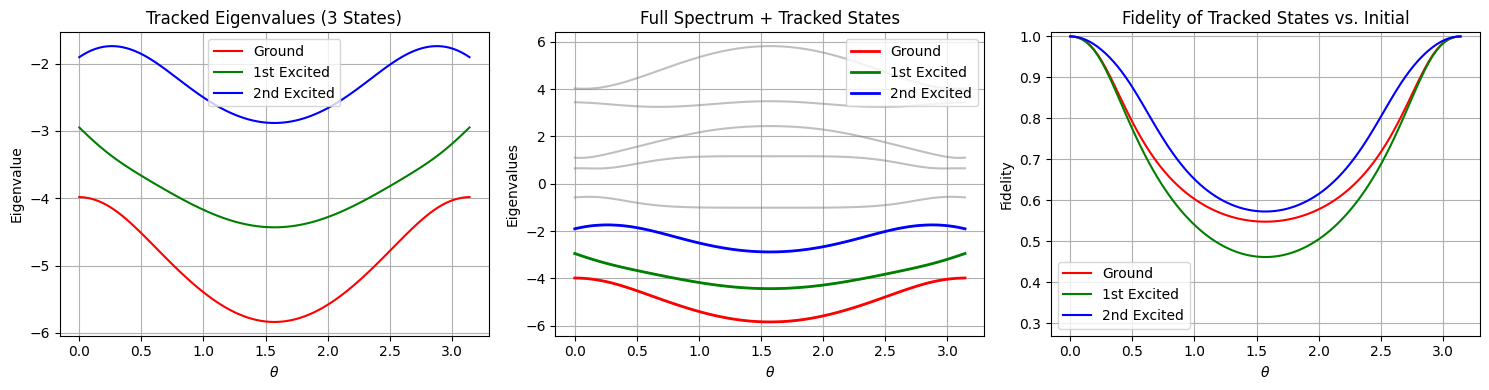

In [18]:
# Track 3 eigenstates: indices 0 (ground), 1 (1st excited), 2 (2nd excited) at theta = 0

# Diagonalize at theta = 0
evals0, evecs0 = eigh(H(0))
initial_indices = [0, 1, 2]  # indices of the 3 lowest eigenstates
tracked_vectors = [evecs0[:, i] for i in initial_indices]
tracked_eigvals = [[] for _ in initial_indices]
tracked_fidelities = [[] for _ in initial_indices]
stored_vectors = [[] for _ in initial_indices]
full_spectrum = []
# Step through theta values
for theta in theta_vals:
    evals, evecs = eigh(H(theta))
    full_spectrum.append(evals)
    #lowest_eigval.append(vals[0])  # Always the ground state

    #lowest_eigval = np.array(lowest_eigval)
    
    used_indices = set()
    next_vectors = [None] * len(initial_indices)
    
    # Build overlap matrix
    overlaps = np.abs(np.array([
        [np.vdot(prev_v, evecs[:, j]) for j in range(n)]
        for prev_v in tracked_vectors
    ]))
    
    # Greedy assignment: highest unmatched overlaps
    for i in range(len(initial_indices)):
        # mask used indices to avoid duplicate matches
        overlaps[i, list(used_indices)] = -1
        j = np.argmax(overlaps[i])
        used_indices.add(j)
        next_vectors[i] = evecs[:, j]
        tracked_eigvals[i].append(evals[j])
        tracked_fidelities[i].append(np.abs(np.vdot(evecs0[:, initial_indices[i]], evecs[:, j])))
        stored_vectors[i].append(evecs[:, j])
    
    tracked_vectors = next_vectors  # update for next step
full_spectrum = np.array(full_spectrum)

# Convert to numpy arrays
tracked_eigvals = [np.array(vals) for vals in tracked_eigvals]
tracked_fidelities = [np.array(fids) for fids in tracked_fidelities]

# Plotting
plt.figure(figsize=(15, 4))

# --- Plot 1: Tracked eigenvalues ---
plt.subplot(1, 3, 1)
colors = ['red', 'green', 'blue']
labels = ['Ground', '1st Excited', '2nd Excited']
for i in range(3):
    plt.plot(theta_vals, tracked_eigvals[i], label=labels[i], color=colors[i])
plt.xlabel(r'$\theta$')
plt.ylabel('Eigenvalue')
plt.title('Tracked Eigenvalues (3 States)')
plt.grid(True)
plt.legend()

# --- Plot 2: Full Spectrum with Tracked States ---
plt.subplot(1, 3, 2)
for i in range(n):
    plt.plot(theta_vals, full_spectrum[:, i], 'gray', alpha=0.5)
for i in range(3):
    plt.plot(theta_vals, tracked_eigvals[i], label=labels[i], color=colors[i], linewidth=2)
plt.xlabel(r'$\theta$')
plt.ylabel('Eigenvalues')
plt.title('Full Spectrum + Tracked States')
plt.grid(True)
plt.legend()

# --- Plot 3: Fidelities ---
plt.subplot(1, 3, 3)
for i in range(3):
    plt.plot(theta_vals, tracked_fidelities[i], label=labels[i], color=colors[i])
plt.xlabel(r'$\theta$')
plt.ylabel('Fidelity')
plt.ylim(0.27, 1.01)
plt.title('Fidelity of Tracked States vs. Initial')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# Define a Hamiltonian that has a controllable degeneracy
def H_deg(theta):
    """Hamiltonian with degeneracy at theta = pi"""
    # Fixed part (Hermitian)
    A = np.diag(np.linspace(-1, 1, n))  # diagonal with increasing values
    B = np.zeros((n, n))
    B[0, 1] = B[1, 0] = 1  # only couple state 0 and 1
    
    # At theta = 0, mostly A; at theta = pi, degeneracy is introduced
    return A + np.cos(theta) * B

# Choose a range of theta around the degeneracy
theta_vals_deg = np.linspace(0, 2 * np.pi, 100)
degeneracy_index = [0, 1]  # We'll track the degenerate subspace spanned by state 0 and 1 at theta = pi

# Get eigenvectors at theta = pi (degeneracy point)
theta0 = np.pi
evals0, evecs0 = eigh(H_deg(theta0))
deg_subspace = evecs0[:, degeneracy_index]  # shape (n, 2)
P0 = deg_subspace @ deg_subspace.conj().T  # projector onto the degenerate subspace

# Track subspace overlap fidelity
subspace_fidelity = []

for theta in theta_vals_deg:
    evals, evecs = eigh(H_deg(theta))
    current_subspace = evecs[:, degeneracy_index]
    P_theta = current_subspace @ current_subspace.conj().T
    fidelity = np.trace(P0 @ P_theta).real  # should be in [0, 2] for 2D subspace
    subspace_fidelity.append(fidelity)

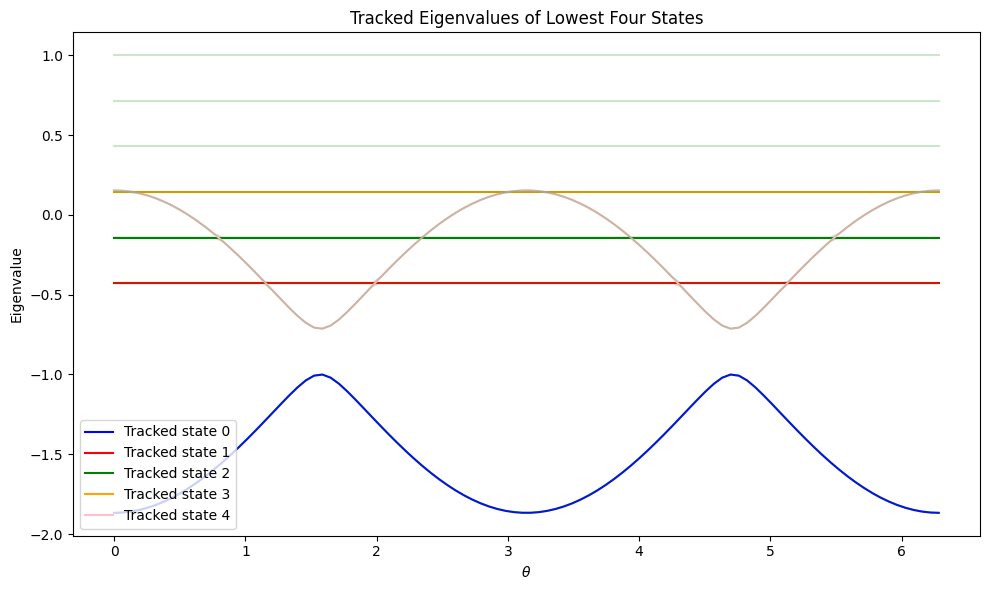

In [27]:
# Number of states to track
num_track = 5

# Start at theta = 0
evals_start, evecs_start = eigh(H_deg(theta_vals_deg[0]))
tracked_vecs = [evecs_start[:, i] for i in range(num_track)]
tracked_evals = [[] for _ in range(num_track)]

# Store initial eigenvalues
for i in range(num_track):
    tracked_evals[i].append(evals_start[i])

# Track over theta
prev_vecs = tracked_vecs.copy()

for theta in theta_vals_deg[1:]:
    evals, evecs = eigh(H_deg(theta))
    assigned = np.zeros(n, dtype=bool)
    new_vecs = []

    for i in range(num_track):
        overlaps = np.array([np.abs(np.vdot(prev_vecs[i], evecs[:, j])) if not assigned[j] else -1 for j in range(n)])
        idx = np.argmax(overlaps)
        assigned[idx] = True
        new_vecs.append(evecs[:, idx])
        tracked_evals[i].append(evals[idx])

    prev_vecs = new_vecs

# Plot tracked eigenvalues of the 4 states
plt.figure(figsize=(10, 6))

colors = ['blue', 'red', 'green', 'orange', 'pink']
labels = [f"Tracked state {i}" for i in range(num_track)]

for i in range(num_track):
    plt.plot(theta_vals_deg, tracked_evals[i], label=labels[i], color=colors[i])

# Also plot the full spectrum for context
spectrum = np.array([eigh(H_deg(theta))[0] for theta in theta_vals_deg])
for i in range(n):
    plt.plot(theta_vals_deg, spectrum[:, i], color='green', alpha=0.2)

plt.title("Tracked Eigenvalues of Lowest Four States")
plt.xlabel(r'$\theta$')
plt.ylabel('Eigenvalue')
plt.legend()
plt.tight_layout()
plt.show()
